In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from transformers import pipeline
from transformers import BartTokenizer, BartForConditionalGeneration

import scipy.stats as stats

from scipy.spatial.distance import pdist, squareform
from sklearn import linear_model
from sklearn.metrics import r2_score

import unicodedata

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [17]:
def get_p_string(p):
    if p >= 0.05:
        return "-"
    elif 0.01 <= p < 0.05:
        return "*"
    elif 0.001 <= p < 0.01:
        return "**"
    else:
        return "***"

def make_scatter_plot(df, x_feat, x_name, y_feat, y_name, alpha_th=0.6, fontsize_th=14, lr_mode=True):
    data_idx = df[[x_feat, y_feat]].dropna().index.values

    corr_v, corr_pvalue = stats.pearsonr(df.loc[data_idx, x_feat].values, df.loc[data_idx, y_feat].values)
    print("Correlation value", corr_v)
    print("P-value", get_p_string(corr_pvalue))

    plt.figure(figsize=(12, 5))

    if lr_mode:
        lr = linear_model.LinearRegression(n_jobs=-1)
        lr.fit(df.loc[data_idx, x_feat].values.reshape(-1, 1), df.loc[data_idx, y_feat])
        y_pred = lr.predict(df.loc[data_idx, x_feat].values.reshape(-1, 1))

        print("Coefficients: \n", lr.coef_, "\nIntercept: \n", lr.intercept_)
        print("R-square: %.2f" % r2_score(df.loc[data_idx, y_feat], y_pred))

        plt.plot(df.loc[data_idx, x_feat], y_pred, c="red", label="Linear Regression")
        plt.legend(fontsize=12)
        delta_int = np.abs(np.nanmax(df[y_feat]) - np.nanmin(df[y_feat]))
        plt.ylim(np.nanmin(df[y_feat]) - 0.1 * delta_int, np.nanmax(df[y_feat]) + 0.1 * delta_int)

    plt.scatter(df[x_feat], df[y_feat], alpha=0.6)

    plt.xlabel(x_name, fontsize=14)
    plt.ylabel(y_name, fontsize=14)

    plt.show()

In [2]:
# https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration

t0 = time.time()

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
# summarizer.model.to("cuda")

ARTICLE = """ 
New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York.
A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.
Only 18 days after that marriage, she got hitched yet again. 
Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other.
In 2010, she married once more, this time in the Bronx. 
In an application for a marriage license, she stated it was her "first and only" marriage.
Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," 
referring to her false statements on the
2010 marriage license application, according to court documents.
Prosecutors said the marriages were part of an immigration scam.
On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, 
Christopher Wright, who declined to comment further.
After leaving court, 
Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking 
into the New York subway through an emergency exit, said Detective
Annette Markowski, a police spokeswoman. 
In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.
All occurred either in Westchester County, Long Island, New Jersey or the Bronx. 
She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say.
Prosecutors said the immigration scam involved some of her husbands, 
who filed for permanent residence status shortly after the marriages.
Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted.
The case was referred to the Bronx District Attorney\'s Office by 
Immigration and Customs Enforcement and the Department of Homeland Security\'s
Investigation Division. 
Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali.
Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation 
by the Joint Terrorism Task Force.
If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.
"""

answer = summarizer(ARTICLE, max_length=100, min_length=30, do_sample=False)

print("Time spend", np.round(time.time()-t0, 2), "s")

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Time spend 352.53 s


In [3]:
print(answer[0]["summary_text"])

Liana Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say. She pleaded not guilty at State Supreme Court in the Bronx.


In [19]:
max_length_list = [30, 50, 70, 100, 120, 150, 200]

result_list = []
for max_len_th in max_length_list:
    t0 = time.time()
    answer = summarizer(ARTICLE, max_length=max_len_th, min_length=30, do_sample=False)
    time_spend = time.time() - t0
    result_list.append({
        "NumCharacters": len(answer[0]["summary_text"]),
        "NumWords": len(answer[0]["summary_text"].split()),
        "MaxLength": max_len_th,
        "Time_s": time_spend
    })
    
df_result = pd.DataFrame(result_list)
df_result

,NumCharacters,NumWords,MaxLength,Time_s
0,120,21,30,4.650292
1,207,39,50,6.465548
2,284,52,70,7.724253
3,284,52,100,7.740286
4,284,52,120,7.831002
5,284,52,150,7.752768
6,284,52,200,7.757308


Correlation value 0.6934660339210112
P-value -
Coefficients: 
 [0.13932432] 
Intercept: 
 31.38378378378379
R-square: 0.48


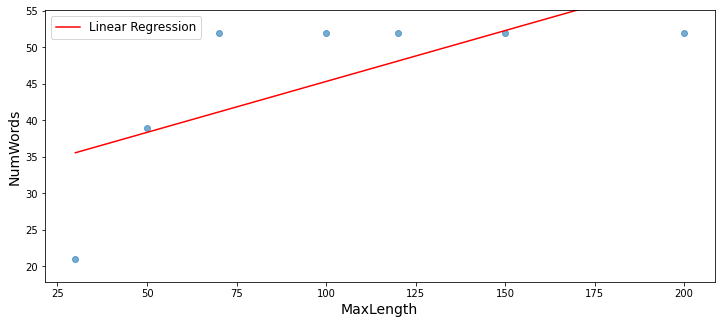

Correlation value 0.6965654666559099
P-value -
Coefficients: 
 [0.01403931] 
Intercept: 
 5.6875939021239414
R-square: 0.49


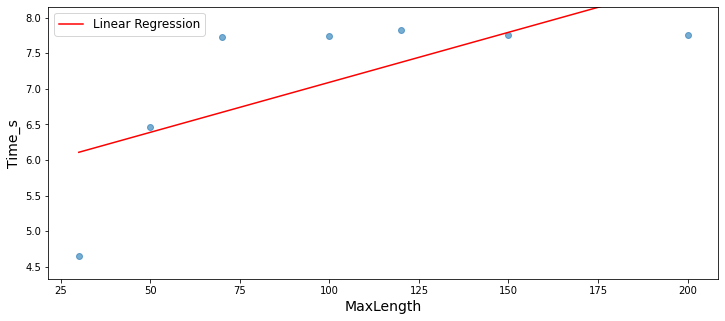

In [21]:
make_scatter_plot(df=df_result, x_feat="MaxLength", x_name="MaxLength", y_feat="NumWords", y_name="NumWords")

make_scatter_plot(df=df_result, x_feat="MaxLength", x_name="MaxLength", y_feat="Time_s", y_name="Time_s")

In [29]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [30]:
all_df_list = []
for conv in os.listdir("../Conversations/"):
    excel_name = [file for file in os.listdir("../Conversations/" + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel("../Conversations/" + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 6


In [34]:
df_x

,SubjectId,SubjectName,TimeInitStr,TimeEndStr,UnixTimestampInit,UnixTimestampEnd,Source,SpanishMessage,EnglishMessage,Mode
0,JoseID7,Jose,2022-07-13 20:11:58.363894,2022-07-13 20:11:58.363894,1.657736e+09,1.657736e+09,Person,Como te llamas?,What's your name?,write
1,JoseID7,Jose,2022-07-13 20:11:58.802435,2022-07-13 20:12:02.154849,1.657736e+09,1.657736e+09,Bot,Mi nombre es Susan y soy un graduado universit...,"My name is Susan, and I am a college graduate...",write
2,JoseID7,Jose,2022-07-13 20:12:07.859059,2022-07-13 20:12:17.919635,1.657736e+09,1.657736e+09,Person,"Hola Susan, que tal estas ?","Hello Susan, how are you?",write
3,JoseID7,Jose,2022-07-13 20:12:19.274752,2022-07-13 20:12:20.753808,1.657736e+09,1.657736e+09,Bot,"Hola, estoy bien.¿Como estas?Estoy bien.","Hi, I am doing well. How are you doing? I am ...",write
4,JoseID7,Jose,2022-07-13 20:12:26.65794,2022-07-13 20:12:36.530307,1.657736e+09,1.657736e+09,Person,"Yo estoy muy bien, mi nombre es Jose","I'm very good, my name is Jose",write
5,JoseID7,Jose,2022-07-13 20:12:37.362226,2022-07-13 20:12:39.616026,1.657736e+09,1.657736e+09,Bot,"Hola José, gusto en conocerte.¿A qué te dedicas?","Hi Jose, nice to meet you. What do you do for...",write
6,JoseID7,Jose,2022-07-13 20:12:44.544372,2022-07-13 20:12:52.404147,1.657736e+09,1.657736e+09,Person,Pues soy analista de datos y tu ?,"Well, am I data analyst and you?",write
7,JoseID7,Jose,2022-07-13 20:12:53.122663,2022-07-13 20:12:55.681505,1.657736e+09,1.657736e+09,Bot,"No estoy seguro de a qué te refieres con eso, ...","I'm not sure what you mean by that, but I wor...",write
8,JoseID7,Jose,2022-07-13 20:13:00.870875,2022-07-13 20:13:27.223804,1.657736e+09,1.657736e+09,Person,"Bueno me voy, adios","Well, gotta go, bye",write
9,JoseID7,Jose,2022-07-13 20:13:28.125484,2022-07-13 20:13:30.38480,1.657736e+09,1.657736e+09,Bot,"¡Adiós, espero que tengas un gran día?!","Goodbye, I hope you have a great day!?!",write
